# OUTPUT TRACKING ALGORITHM


---
Author: **Helvecio B. Leal Neto** & **Alan J. P. Calheiros**\
**National Institute for Space Research - Brazil - (2021)**



## About

This notebook is designed for viewing the tracking results of the storm/precipitation tracking algorithm beta version. The results presented here refer to the tracking of clusters via radar data provided by the GoAmazon project, for the following periods:

**Start**: 2014-09-07 00:00:00

**End**: 2014-09-09 00:00:00

The tracking threshold is:

* **20** dBZ
* inner 1 - ***35*** dBZ
* inner 2 - ***40*** dBZ

Minimum size threshold per cluster:

* **30** pixels
* inner 1 - ***15*** pixels
* inner 2 - ***10*** pixels

## Dependencies libraries

In [7]:
# Dataframe library
import pandas as pd
# Numerical Python library
import numpy as np
# netCDF4 library
import netCDF4
# Import gzip to open netCDF
import gzip
# Visualization library
import matplotlib.pyplot as plt

## Variables

**Fam_Nº**-> Refers to the number of the Tracked Family.
<br>

**timestamp** ->A digital record of the time of occurrence of a particular event.
<br>
**time** -> Refers to the tracking time in the algorithm.
<br>
**uid** -> Unique IDentifier, it is used to generate the families.
<br>
**id_t** -> Referring cluster identifier at the time of tracking occurrence. From the DBSCAN clustering algorithm.
<br>
**lat** -> Refers latitude centroid, taken from the reference matrix of the original nc files.
<br>
**lon** -> Refers longitude centroid, taken from the reference matrix of the original nc files.
<br>
**p0** -> The first coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**p1** -> The second coordinate point of centroid in matrix (clusters or nc_file): (p0,p1)=(x,y)=(lon,lat).
<br>
**size_%THRESHOLD** -> Total number of Pixels in the main cluster. Each point depends on the sensor's spatial resolution (pixel size): RADAR 2x2km.
<br>
**mean_ref_%THRESHOLD** -> Averaged reflectivity of the cluster. Value in dBZ.
<br>
**max_ref_%THRESHOLD** -> Max reflectivity of the cluster. Value in dBZ.
<br>
**angle_%THRESHOLD_orig** -> Original displacement angle of the cluster at the current time.
<br>
**angle_%THRESHOLD_cor** -> Corrected displacement angle of the cluster at the current time. 
<br>
**vel_%THRESHOLD_orig** -> Original displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**vel_%THRESHOLD_cor** -> Corrected displacement velocity of the cluster at the current time in kilometers per hour (km/h).
<br>
**mean_total_ref_%THRESHOLD** -> Average reflectivity of the inner clusters by threshold (Value in dBZ).
<br>
**total_size_%THRESHOLD** -> Total size of inner clusters by threshold (number of pixels).
<br>
**n_cluster_%THRESHOLD** -> Total number of inner clusters by Threshold.
<br>
**avg_angle_%THRESHOLD** -> Averaged angle for the inner cluster by threshold (Value in degree).
<br>
**avg_vel_%THRESHOLD** -> Averaged velocity for inner clusters by threshold (Value in km/h).
<br>
**status** -> Status of occurrence, type: NEW-> New cluster; CONT-> Continous cluster; SPLT -> Splitted cluster; MERG -> Merged Cluster.
<br>
**delta_t** -> Time interval for cluster life cycle.
<br>
**nc_file** -> Path of netCDF file.
<br>
**cluster_file** -> Path of cluster file (From DBSCAN).
<br>
**dsize_%THRESHOLD** -> Difference between the sizes of two consecutive clusters (in Pixel).
<br>
**dmean_ref_%THRESHOLD** -> Difference between the mean reflectivities of two consecutive clusters for main threshold (in dBZ).
<br>
**dmean_total_ref_%THRESHOLD** -> Difference between the mean reflectivities of all clusters between two consecutive times for an inner threshold (in dBZ).
<br>
**dtotal_size_%THRESHOLD** -> Difference between the total size (in pixel) of all clusters between two consecutive times for an inner threshold (values in pixel).

## Read tracking file

Tracking DataFrame.

In [29]:
fam_tracking = pd.read_pickle("./S201409070000_E201409100000_VDBZc_T20_L5.pkl")
fam_tracking

timestamp  time  uid  id_t       lat        lon     p0  \
Fam_0  0    2014-09-07 00:00:00     0    0     2 -1.423926 -60.710175  216.0   
       10   2014-09-07 00:12:00     1    0     3 -1.495779 -60.728176  212.0   
Fam_1  1    2014-09-07 00:00:00     0    1     5 -2.358212 -60.602760  164.0   
       11   2014-09-07 00:12:00     1    1     4 -2.412090 -60.638752  161.0   
Fam_10 20   2014-09-07 00:24:00     2   10     8 -1.675547 -60.512596  202.0   
...                         ...   ...  ...   ...       ...        ...    ...   
Fam_97 533  2014-09-07 19:00:00    95   97    20 -3.094856 -60.531185  123.0   
       548  2014-09-07 19:12:00    96   97    15 -3.130749 -60.603176  121.0   
       566  2014-09-07 19:24:00    97   97    21 -3.202613 -60.603218  117.0   
Fam_98 538  2014-09-07 19:00:00    95   98    44 -3.130779 -59.433620  121.0   
       554  2014-09-07 19:12:00    96   98    39 -3.148715 -59.379631  120.0   

               p1  size_20  mean_ref_20  ...  status          delta_t  \
Fam_0  0     80.0     66.0    35.540233  ...     NEW  0 days 00:00:00   
       10    79.0     34.0    26.850009  ...    CONT  0 days 00:12:00   
Fam_1  1     86.0     75.0    39.058735  ...     NEW  0 days 00:00:00   
       11    84.0     41.0    37.308171  ...    CONT  0 days 00:12:00   
Fam_10 20    91.0     82.0    38.440909  ...    CONT  0 days 00:00:00   
...           ...      ...          ...  ...     ...              ...   
Fam_97 533   90.0    169.0    40.267625  ...    MERG  0 days 00:00:00   
       548   86.0    215.0    37.533064  ...    MERG  0 days 00:12:00   
       566   86.0    160.0    37.018101  ...    CONT  0 days 00:24:00   
Fam_98 538  151.0    209.0    40.025382  ...    MERG  0 days 00:00:00   
       554  154.0    238.0    39.563215  ...    CONT  0 days 00:12:00   

                                        nc_file  \
Fam_0  0    data/sbmn_cappi_20140907_0000.nc.gz   
       10   data/sbmn_cappi_20140907_0012.nc.gz   
Fam_1  1    data/sbmn_cappi_20140907_0000.nc.gz   
       11   data/sbmn_cappi_20140907_0012.nc.gz   
Fam_10 20   data/sbmn_cappi_20140907_0024.nc.gz   
...                                         ...   
Fam_97 533  data/sbmn_cappi_20140907_1900.nc.gz   
       548  data/sbmn_cappi_20140907_1912.nc.gz   
       566  data/sbmn_cappi_20140907_1924.nc.gz   
Fam_98 538  data/sbmn_cappi_20140907_1900.nc.gz   
       554  data/sbmn_cappi_20140907_1912.nc.gz   

                                cluster_file  dsize_20  dmean_ref_20  \
Fam_0  0    clusters/20140907_000000_clu.npz       NaN           NaN   
       10   clusters/20140907_001200_clu.npz     -32.0     -8.690224   
Fam_1  1    clusters/20140907_000000_clu.npz       NaN           NaN   
       11   clusters/20140907_001200_clu.npz     -34.0     -1.750565   
Fam_10 20   clusters/20140907_002400_clu.npz       NaN           NaN   
...                                      ...       ...           ...   
Fam_97 533  clusters/20140907_190000_clu.npz       NaN           NaN   
       548  clusters/20140907_191200_clu.npz      46.0     -2.734561   
       566  clusters/20140907_192400_clu.npz     -55.0     -0.514963   
Fam_98 538  clusters/20140907_190000_clu.npz       NaN           NaN   
       554  clusters/20140907_191200_clu.npz      29.0     -0.462167   

            dtotal_size_35  dmean_total_ref_35  dtotal_size_40  \
Fam_0  0               NaN                 NaN             NaN   
       10              NaN                 NaN             NaN   
Fam_1  1               NaN                 NaN             NaN   
       11             -9.0           -2.209392            -3.0   
Fam_10 20              NaN                 NaN             NaN   
...                    ...                 ...             ...   
Fam_97 533             NaN                 NaN             NaN   
       548           -12.0           -1.112704           -18.0   
       566            -9.0           -0.993915             0.0   
Fam_98 538             NaN                 NaN

### Example how to select a FAM by uid

In [30]:
uid = 97
selected_fam = fam_tracking.query('uid == @uid')
selected_fam

timestamp  time  uid  id_t       lat        lon     p0  \
Fam_97 533  2014-09-07 19:00:00    95   97    20 -3.094856 -60.531185  123.0   
       548  2014-09-07 19:12:00    96   97    15 -3.130749 -60.603176  121.0   
       566  2014-09-07 19:24:00    97   97    21 -3.202613 -60.603218  117.0   

              p1  size_20  mean_ref_20  ...  status          delta_t  \
Fam_97 533  90.0    169.0    40.267625  ...    MERG  0 days 00:00:00   
       548  86.0    215.0    37.533064  ...    MERG  0 days 00:12:00   
       566  86.0    160.0    37.018101  ...    CONT  0 days 00:24:00   

                                        nc_file  \
Fam_97 533  data/sbmn_cappi_20140907_1900.nc.gz   
       548  data/sbmn_cappi_20140907_1912.nc.gz   
       566  data/sbmn_cappi_20140907_1924.nc.gz   

                                cluster_file  dsize_20  dmean_ref_20  \
Fam_97 533  clusters/20140907_190000_clu.npz       NaN           NaN   
       548  clusters/20140907_191200_clu.npz      46.0     -2.734561   
       566  clusters/20140907_192400_clu.npz     -55.0     -0.514963   

            dtotal_size_35  dmean_total_ref_35  dtotal_size_40  \
Fam_97 533             NaN                 NaN             NaN   
       548           -12.0           -1.112704           -18.0   
       566            -9.0           -0.993915             0.0   

            dmean_total_ref_40  
Fam_97 533                 NaN  
       548            0.054312  
       566           -1.984973  

[3 rows x 35 columns]

## Example how to select a cluster in the family

In [31]:
line = 0 #first line 

selected_line = selected_fam.iloc[[line]]
selected_line

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,status,delta_t,nc_file,cluster_file,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40
Fam_97,533,2014-09-07 19:00:00,95,97,20,-3.094856,-60.531185,123.0,90.0,169.0,40.267625,...,MERG,0 days 00:00:00,data/sbmn_cappi_20140907_1900.nc.gz,clusters/20140907_190000_clu.npz,NaN,NaN,NaN,NaN,NaN,NaN


## Example how to open the cluster file and the original data to extract reflectivity values

In [32]:
## OPEN CLUSTERS
def open_cluster(path):
    try:
        cluster = np.load(path['cluster_file'].values[0])['arr_0']
        cluster[cluster == 0] = np.NAN
        return cluster
    except:
        print('File not found!')

In [33]:
selected_line

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,status,delta_t,nc_file,cluster_file,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40
Fam_97,533,2014-09-07 19:00:00,95,97,20,-3.094856,-60.531185,123.0,90.0,169.0,40.267625,...,MERG,0 days 00:00:00,data/sbmn_cappi_20140907_1900.nc.gz,clusters/20140907_190000_clu.npz,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
cluster_matrix_all = open_cluster(selected_line)
print('Original dimensions of cluster->',cluster_matrix_all.shape)

THRESHOLD_LEVEL = 0 #to select the main threshold (ex: 0-20dBZ,1-35dBZ,2-40dBZ)
cluster_matrix = cluster_matrix_all[:,:,THRESHOLD_LEVEL]
print('Selected dimensions of cluster->',cluster_matrix.shape)

Original dimensions of cluster-> (241, 241, 3)
Selected dimensions of cluster-> (241, 241)


In [37]:
### OPEN NETCDF
def open_file(file_path):
    VAR_NAME = 'DBZc'
    LEVEL = 5 #2.5km height
    THRESHOLDS = [20,35,40] #dBZ
    with gzip.open(file_path['nc_file'].values[0]) as gz:
        with netCDF4.Dataset('dummy', mode='r', memory=gz.read()) as nc:
            data = nc.variables[VAR_NAME][0][LEVEL][:].filled()
            data[data == -9999.] = np.NAN
    data[data < THRESHOLDS[0]] = np.nan
    return data

In [38]:
nc_matrix = open_file(selected_line)
print('NetCDF Max/Min values (thresholded):\n',np.nanmax(nc_matrix),np.nanmin(nc_matrix))

NetCDF Max/Min values (thresholded):
 57.013268 20.001736


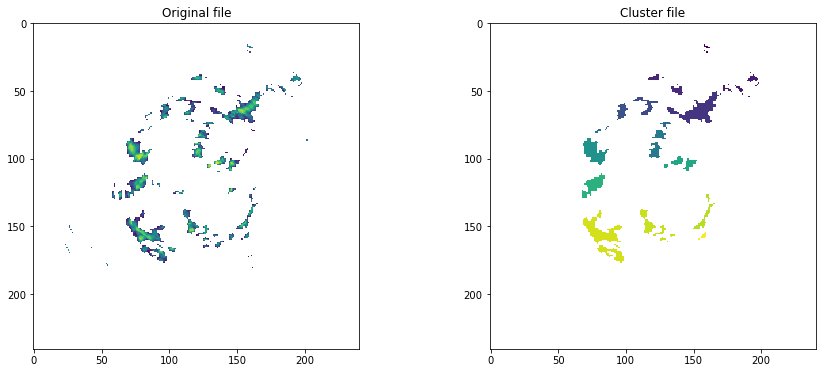

In [39]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))

ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

## Extracting reflectivities from the selected cluster

To extract the reflectivity values of an individual cluster, you will need to choose the tracking 'id_t', this should be done as follows:

Visualization of individual line.

In [40]:
selected_line

,,timestamp,time,uid,id_t,lat,lon,p0,p1,size_20,mean_ref_20,...,status,delta_t,nc_file,cluster_file,dsize_20,dmean_ref_20,dtotal_size_35,dmean_total_ref_35,dtotal_size_40,dmean_total_ref_40
Fam_97,533,2014-09-07 19:00:00,95,97,20,-3.094856,-60.531185,123.0,90.0,169.0,40.267625,...,MERG,0 days 00:00:00,data/sbmn_cappi_20140907_1900.nc.gz,clusters/20140907_190000_clu.npz,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
### This line shows that id_t is equal to 20. 
selected_id_t = selected_line.id_t.values[0]

### Get XY coordinates from cluster matrix
x,y = np.where(cluster_matrix == selected_id_t)

### Get reflectivities values from nc_file cluster
dbz_list = nc_matrix[x,y]

In [42]:
print('List with reflectivity values of an individual cluster.\n',dbz_list)

List with reflectivity values of an individual cluster.
 [22.51749  22.050047 30.712986 42.382034 42.623783 30.82245  21.493246
 25.210854 34.032623 38.4685   35.082436 27.324896 20.257221 32.58981
 35.424877 30.070417 31.163326 31.48108  26.107399 21.404022 25.798033
 35.456642 42.64063  44.22215  36.10894  27.364614 30.833633 31.592962
 27.062992 20.62784  44.217888 49.803005 47.170597 40.912865 37.80369
 28.715801 28.915613 22.296438 20.07925  31.724625 41.066936 47.848907
 39.303276 34.319427 37.13572  40.94689  40.903564 33.228706 25.67938
 30.803814 41.14029  42.566814 32.25733  22.671242 28.067188 36.9665
 36.280582 29.785559 30.344921 26.415358 24.325996 23.194563 24.396069
 20.993702 21.824558 20.890003 20.56245  25.351124 22.178925 21.430916
 26.824734 25.40326  20.9057   33.181545 25.525124 20.069637 28.32751
 49.61959  49.11052  45.621357 46.900436 38.449356 24.015781 33.79105
 38.336872 35.15806  37.129875 28.310795 20.550978 26.331312 25.42406
 23.593359 28.278854 33.0257

### Cluster location view

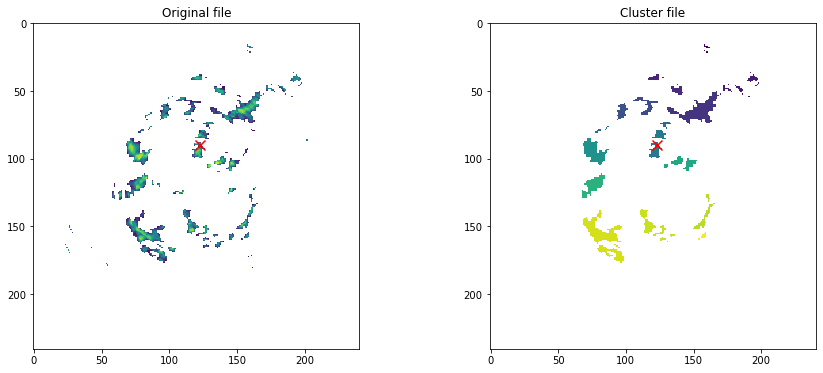

In [43]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,6))
ax.imshow(nc_matrix)
ax1.imshow(cluster_matrix);
ax.set_title('Original file')
ax1.set_title('Cluster file');

ax.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)
ax1.scatter(selected_line.p0,selected_line.p1,marker='x',color='r',s=100)